# League of Legends Match Analytics
## Introduction

League of Legends is a competitive video game owned by Riot Games in which 10 players compete against each other in teams of 5. It is one of the most played and viewed video games in the world. Since 2011, Riot Games has hosted professional "leagues" in various regions around the world. The best teams from each region come to the Wold Championship where the best team wins the Summoner's Cup. Since its inception, the World Championship has been dominated by the Korean teams. This is an attempt to apply data driven methods to find latent variables that can explain the Korean dominance in professional League of Legends matches. All of the data has been kindly provided by [Tim Sevenhuysen](https://twitter.com/TimSevenhuysen) on his website: [Oracle's Elixir](https://oracleselixir.com/).

## Exploratory analysis

To make the analysis easier, I'm doing to import a bunch of packages and define some methods first

In [1]:
import sys
sys.path.append(".//utils//")
import sqlite3, os
import pandas as pd
import parsing_utils
from parsing_utils import parse_databases
import importlib
importlib.reload(parsing_utils)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import display_html

def reset_dir():
    os.chdir("C:\\Users\Brook Wassie\Dropbox\My Documents\EdX\machine-learning-master\machine-learning-master\SQL project\lck\LoL match analytics\LoL-match-analytics")

def display_side_by_side(series, names, feature):
    srs = []
    n=0
    for ii in series:
        ii = pd.DataFrame(ii.rename_axis(names[n],axis=0).rename(feature))
        ii[names[n]] = ii.index
        ii = ii.reset_index(drop=True)
        ii.index = np.arange(1, len(ii) + 1)
        srs.append(ii.loc[:,[names[n],feature]])
        n+=1
    final_table = pd.concat(srs,axis=1)
    #display(final_table)
    return final_table

def get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins):
    all_matches = {}
    all_teams = {}
    parser = parse_databases()
    for ii, jj in zip(aliases,leagues):
        alias = ii
        league = jj
        name = "{}_{}_{}_{}s".format(year,alias,season,focus)
        matches,teams  = parser.parse_tables_get_matches(db_dir,alias,joins,anti_joins,name,year,league)
        try:
            name = matches["league"].value_counts().index.values[0]
            all_matches[name] = matches
            all_teams[name] = teams
            #print(matches["league"].value_counts())
        except:
            print("League {} does not have any data for {}".format(jj,season))
    return all_matches, all_teams

def get_fig_axes(n=1,m=2,w=10,h=5,sharey=False):
    fig,ax = plt.subplots(n,m,figsize=(w,h),sharey=sharey)
    axes = ax.flatten()
    return fig,axes

reset_dir()
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
query = "select * from 'sqlite_master' where type = 'table';"
#cursor = match.cursor()
#cur_exec = cursor.execute(query)
#print(pd.read_sql_query(query,match))

Now, if we look at the top 5 teams from the World Championships since 2014, we can see that Korean and Chinese teams usually dominate the field:

In [ ]:
#os.chdir("C:\\Users\Brook Wassie\Dropbox\My Documents\EdX\machine-learning-master\machine-learning-master\SQL project\lck\LoL match analytics\LoL-match-analytics")
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
regions = {'2014':['Korea','Korea','Korea','China','China'],'2015':['Korea','Korea','Europe','Europe','Korea'],
          '2016':['Korea','Korea','Korea','Europe','China'],'2017':['Korea','Korea','China','China','Korea']}
fig,ax = plt.subplots(1,4,figsize=(14,3), sharey=True)
axes = ax.flatten()
colors = {'Korea':'r','China':'b','Europe':'g'}
n=0
axes[0].set_ylabel("Number of teams")
for ii in ['2014','2015','2016','2017']:
    query="""SELECT name FROM international.'sqlite_master' WHERE type = 'table' 
    AND name LIKE '%championships%' AND name LIKE '%team%' AND name LIKE '%{}%';""".format(ii)
    table = pd.read_sql_query(query,match).iloc[0,0]
    query="""SELECT * FROM international.'{}' ORDER BY W DESC, L ASC;""".format(table)
    top5 = pd.read_sql_query(query,match).head(5)
    top5["Region"] = regions[ii]
    cols = [colors[ii] for ii in top5["Region"].value_counts().index.values]
    top5["Region"].value_counts().plot.bar(ax = axes[n], color = [cols])
    axes[n].set_title("{}".format(ii))
    n+=1
plt.suptitle("Regions of the Top 5 Worlds Championship teams",y=1.1)
legend = [plt.Line2D([0],[0],color='r',label='Korea'),plt.Line2D([0],[0],color='b',label='China')
          ,plt.Line2D([0],[0],color='g',label='Europe')]
plt.legend(handles=legend, loc='upper right',bbox_to_anchor=(1, 1.5))
plt.tight_layout()
plt.show()

European teams have made it into the top 5 in 2015 and 2016 but Korean teams have been 3 out of the top 5 teams consistently. Since 2013, Korean teams have also won the World Championship. There has been much speculation about the Korean dominance in the professional League of Legends circuit. In particular, many people have wondered why North America never seems to make it into the top 5 despite having the largest recruiting pool and the most enthusiastic fan base. I will try to answer the question by analyzing matches from the LCK (Korean circuit) and NA (North American circuit). Specifically, I will be comparing LCK with NA matches. I unfortunately only have complete match data for the 2016 and 2017 seasons so I will be limited to the last couple of years. I will start with 2017 first since it is more recent and is not too different in terms of gameplay changes to 2018. Lets see what we can find! 
### Choosing teams
In order to make a fair comparison between the two regions, I have to pick teams that I believe best represent these regions. I decided to use teams that made it to the Spring or Summer season playoffs in the respective years. If a team made it to either of the playoffs that year, that means they must have been better than at least half the teams in their region in that season since only half the teams that compete in a region move to the playoffs. Thus, I will be comparing the top 50% of Korean teams with the top 50% of North American teams in that same year. First let's get the 2017 matches for playoff teams in LCK and NA. I have custom scripts that parse my databases and give me the matches I want. The specific implementation can be found in `parsing_utils.py`. 
### Match team statistics

First, lets look at the overall team stats for each match. This will give us team wide stats for each match rather than each player's stats:

In [ ]:
year = "2017"
focus = "team"
season = "playoffs"
joins = [year,focus,season]
anti_joins = ["na-cs","eu-cs"]
aliases = ["na","lck"]
leagues = ["NALCS","LCK"]
all_matches,all_teams = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)
na = all_matches["NALCS"]
lck = all_matches["LCK"]

The teams that made it to any of the NA playoffs in 2017 played a total of 782 matches together whereas the LCK teams played 606 matches. The reason for this discrepancy becomes clear when we look at the number of teams:

In [ ]:
fig,axes = get_fig_axes(1,2,15,4)
na["team"].value_counts().plot.bar(ax=axes[0],color='b')
axes[0].set_title("Matches played by 2017 NA playoff teams")
lck["team"].value_counts().plot.bar(ax=axes[1],color='r')
axes[1].set_title("Matches played by 2017 LCK playoff teams")
plt.show()

There were only 6 teams from the LCK that made it to either the Spring or Summer playoffs compared with the 8 teams from NA. This seems to suggest that the matches in NA are more competitive than the matches in LCK. We can examine this more closely by looking at the ["GSPD"](https://oracleselixir.com/tag/gspd/) (Gold Spent Percentage Difference) statistic. "GSPD" measures if a match was a close one or if one team dominated. It measures the difference how much gold the winning team spent verses the losing team. If the difference is large, then it means the winning team had a large lead. If it is small or negative, then the losing team was keeping up in gold with the winning team. Lets compare the "GSPD" for NA vs LCK:

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
T_stat,p_val = ttest_ind(na["gspd"].values,lck["gspd"].values)
K_stat,p_val_k = ks_2samp(na["gspd"].values,lck["gspd"].values)
fig,axes = get_fig_axes(1,2,15,4,sharey=True)
na.boxplot('gspd',ax=axes[0])
axes[0].set_title("NA GSPD\nMean: {:10.3f}".format(na["gspd"].mean()))
lck.boxplot('gspd',ax=axes[1])
axes[1].set_title("LCK GSPD\nMean: {:10.3f}".format(lck["gspd"].mean()))
plt.suptitle("T-test p-val: {:10.4f}\nKS-test p-val: {:10.4f}".format(p_val,p_val_k))
plt.show()

Looking at the means and distributions, LCK in general had a higher GSPD than NA. I performed a KS test to measure if the two distributions were significantly different and a T-test for equality of the means. Although the T-test p-value is too high to say the two means are different, we can confidently say that the two distributions are different. We can be a littme more discriminant in our analysis. Lets rank the teams in the respective regions by their win rate and check their average gspd for the whole year:

In [ ]:
s1 = na.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
#s1 = s1.rename_axis("NA Teams",axis=0).rename("2017 avg GSPD")
s2 = lck.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
#s2 = s2.rename_axis("LCK Teams",axis=0).rename("2017 avg GSPD")
names = ["NA Teams","LCK Teams"]
feature = "2017 avg GSPD"
series=[s1,s2]
table = display_side_by_side(series,names,feature)
print(table)

This gives a clearer picture about what's going on. The top 3 NA teams tend to have a higher GSPD than the rest of the NA teams that qualified for playoffs whereas the LCK playoff teams tend to have a high GSPD in general. Again, this supports the notion that NA is more competitive than the LCK; the LCK teams that make it to the playoffs tend to dominate the field (according to the GSPD) whereas the NA teams tend to be more of a mixed bag. That seems interesting. Lets see if we can find a better explanation for why this is. To evaluate which features contribute to the differences between NA and LCK, I will train several models (Logistic Regression, Adaboost with Decision Trees, and Random Forest) and perform an anova to distinguish between matches in NA and LCK. Then I will see which features are the most important in distinguishing between the two groups.  

I will first clean the data for missing values by substituting the mean for some numerical columns, specific values for others, and the mode for categorical variables (this happens in the method `format_table()` in `analytics_utils.py`). I will then one hot encode categorical variables and standard scale the entire dataset.  

The training and testing are part of the `supervised_analysis` class from `analytics_utils.py`. I split the data in testing and training sets. The testing set will be used for 10 fold cross validation and the testing set will be used to calculate the area under the receiving operating characteristic (AUC). Then I extract the top 10 ranked features (for Adaboost, and RandomForest) or the features that had the largest coefficients (for Logistic Regression) and examine them. The coeficients for Logistic Regression normally aren't easy to interpret since different features can have different scales. However, since my features will be normalized to 0, I'm hoping that I can just use the coeficients for each feature to determine their importance to the classificaiton

In [ ]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

leagues = ["NALCS","LCK"]
variable = "league"
to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split"]
matches,data, y, colnames = get_final_table(leagues,variable,to_drop, all_matches)
all_cols = matches.columns.values.tolist()
sup = supervised_analysis(data,y,colnames)
log_comp,log_auc = sup.fit("Logit")
ada_comp,ada_auc = sup.fit("Adaboost")
tree_comp,tree_auc = sup.fit("Random Forest")
anova_comp = sup.anova()
print("Logit auc:{:10.4f}\nAdaboost auc: {:10.4f}\nRandom Forest auc:{:10.4f}\n".format(log_auc,ada_auc,tree_auc))

It seems that Logistic Regression and Adaboost perform quite well at classifying the matches in the correct league compared to Random Forest but all of them do better than random (largest class is 56%). Now lets look at the top 10 features for each algorithm as well as the ANOVA test between NA and LCK:

In [ ]:
num_feats = all_matches["LCK"].loc[:,all_matches["LCK"].dtypes != np.dtype('O')].shape[1]
print("Total # of features: {}".format(matches.shape[1]))
print("Total # of numerical features: {}".format(num_feats))
algs = ["LOGSITIC REGRESSION","ADABOOST","RANDOM FOREST", "ANOVA"]
series=[log_comp[:10],ada_comp[:10],tree_comp[:10],anova_comp[:10]]
table = display_side_by_side(series,algs,"Importance")
display(table)

There are 486 features total (most of these are one hot encoded categorical features...). We see some of the same features appearing in all lists: `cspm`, `wcpm`, and `wpm` show up in all 4 lists. In general however, the features that show up in these lists are related to: gold generation (`cspm`, `earnedgpm`, `csat10`, `monsterkills`, `csat15`, `oppgoldat15`, `cspd`), vision control (`wpm`, `wcpm`, `visionwardbuys`, `wardkills`, `invisiblewardclearrate`), objective control (`fttime`, `oppbaronkills`), action with enemy champions (`dmgtochampsperminute`, `ckpm`, `teamdeaths`), and team composition (`ban1_Rengar`, `ban1_Cassiopeia`, `ban3_Elise`). It's interesting that Logistic Regression is the only one to rank features realted to team compositions. It's also interesting that GSPD also shows up as a predictive feature in Adaboost. 

Lets plot and do a T-Test for the features that intersect in all lists except ANOVA.

In [ ]:
comps = []
complist = [log_comp,tree_comp,ada_comp]
for ii in complist:
    comps.append(ii.index.values[:10].tolist())
    
overlap = list(set(comps[0]).intersection(*comps))
print(overlap)


In [ ]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

n=0
fig,axes = get_fig_axes(2,4,15,6,sharey=False)
for ii in overlap:
    if matches[ii].value_counts().index.shape[0] == 2:
        makeplot(matches,y,ii,"bar",[axes[n],axes[n+1]])
    else:
        makeplot(matches,y,ii,"notbar",[axes[n],axes[n+1]])
    n+=2
plt.tight_layout()
plt.show()

The boxplots seem normally distributed and my sample size is large (hundreds for each NA and LCK) so I feel that a T-Test would be appropriate in this case. There is a difference in these 4 features between NA and LCK teams but it's pretty small. LCK teams have slightly higher `cspm`, which is a measure of how much minions teams kill per minute (and thus a measure of gold generation), `wpm` and `wcpm`, which are measure of how many wards (which grant vision) teams put and clear respectively while NA teams have higher `visionwardbuys` which measures how many vision wards teams buy. This seems to suggest that LCK teams are slightly better at constant gold generation and vision control. It's intersting that NA teams have higher vision ward buys but don't seem to invest in invisible wards which are less likely to be cleared by the enemy team.   

It's interesting that all these differences are actually pretty small but consitent and statistically significant. It seems like the largest differences between NA and LCK come from vision control and gold generation although there might also be other differences in team compositions, fighting (team fights, dueling, kills, deaths...etc), and objective control.

### Examining differences in gold generation, vision control, objective control, team comp, and fighting

I'm going to dive deeper into some of these latent variables and examine player stats and see how they differ between NA and LCK. I will classify different subsets of features into these latent variables based on my knowledge of the game. Not all features will be contained in these sets. 


In [ ]:
#new
gold_gen = ["earnedgoldshare","earnedgpm","gspd","goldspent","minionkills","monsterkills",
           "monsterkillsownjungle","monsterkillsenemyjungle","cspm","goldat10","oppgoldat10","gdat10",
           "goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10","csat15","oppcsat15","csdat15",
           "xpat10","oppxpat10","xpdat10"]
vision = ["wards","wpm","wardshare","wardkills","wcpm","visionwards","visionwardbuys","visiblewardclearrate",
         "invisiblewardclearrate"]
obj_ctr_vs = ["teamdragkills","elementals","firedrakes","waterdrakes","earthdrakes",
          "airdrakes","elders","herald","heraldtime","ft","fttime","firstmidouter",
          "teambaronkills","firsttothreetowers","fbaron","fbarontime"]
action_vs = ["k","d","a","teamkills","doubles","triples","quadras","pentas","fb","fbassist","fbvictim",
             "kpm","fbtime","fd","fdtime","dmgtochamps","dmgtochampsperminute","dmgshare","gamelength"]
team_comp = ["champion","ban1","ban2","ban3","ban4","ban5","position"]
biased = ["okpm","ckpm","opptowerkills","totalgold","oppelders","oppdragkills","oppelementals",
          "oppbaronkills","teamdeaths","teamtowerkills"]


In [ ]:
#old
gold_gen = ["earnedgoldshare","totalgold","earnedgpm","goldspent","gspd","minionkills","monsterkills",
           "monsterkillsownjungle","monsterkillsenemyjungle","cspm","goldat10","oppgoldat10","gdat10",
           "goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10","csat15","oppcsat15","csdat15",
           "xpat10","oppxpat10","xpdat10"]
vision = ["wards","wpm","wardshare","wardkills","wcpm","visionwards","visionwardbuys","visiblewardclearrate",
         "invisiblewardclearrate"]
obj_ctr = ["teamdragkills","oppdragkills","elementals","oppelementals","firedrakes","waterdrakes","earthdrakes",
          "airdrakes","elders","oppelders","herald","heraldtime","ft","fttime","firstmidouter","teamtowerkills",
          "firsttothreetowers","opptowerkills","fbaron","fbarontime","teambaronkills","oppbaronkills"]
action = ["k","d","a","teamkills","teamdeaths","doubles","triples","quadras","pentas","fb","fbassist","fbvictim",
         "fbtime","kpm","okpm","ckpm","fd","fdtime","dmgtochamps","dmgtochampsperminute","dmgshare","gamelength"]
team_comp = ["champion","ban1","ban2","ban3","ban4","ban5","position"]
early_game = ["goldat10","oppgoldat10","gdat10","goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10",
              "csat15","oppcsat15","csdat15","xpat10","oppxpat10","xpdat10","herald","heraldtime"]
obj_ctr_test = ["teamdragkills","oppdragkills","heraldtime","fttime","teamtowerkills","fbaron","fbarontime"]

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)
import math

def get_subset_data(all_player_stats,var,role, variable):
    leagues = []
    player_stats = {}
    for ii in all_player_stats.keys():
        leagues.append(ii)
        s = all_player_stats[ii]
        #print(s.columns.values)
        player_stats[ii] = s.loc[s["position"].str.contains(role),:]
        player_stats[ii] = player_stats[ii].loc[:,var].dropna(axis=1,how="all")
    #print("#NA samples: {}\t#LCK samples: {}".format(na_players.shape[0],lck_players.shape[0]))
    to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split","player","result"]
    #to_drop = to_drop + biased
    return get_final_table(leagues,variable,to_drop, player_stats)

def run_subset_analysis(data,y,colnames,matches=None):
    sup = supervised_analysis(data,y,colnames)
    log_comp, log_auc = sup.fit("Logit")
    ada_comp, ada_auc = sup.fit("Adaboost")
    tree_comp, tree_auc = sup.fit("Random Forest")
    anova_comp = sup.anova()
    auc_dict = {log_auc:log_comp,ada_auc:ada_comp,tree_auc:tree_comp}
    aucs=[log_auc,ada_auc,tree_auc]
    max_comp = max(aucs)
    algs = ["LOGSITIC REGRESSION","ADABOOST","RANDOM FOREST"]#, "ANOVA"]
    aucs2 = dict(zip(aucs,algs))
    print("Best Performing Algorithm is {} with an auc of: {:10.4f}\n".format(aucs2[max_comp],max_comp))
    srs = []
    n=0
    for ii in [log_comp[:10],ada_comp[:10],tree_comp[:10]]:#,anova_comp[:10]]:
        ii = ii.rename_axis(algs[n],axis=0).rename("Importance")
        n+=1
        srs.append(ii)
    algs_table = ["LOGIT: {:10.3f}".format(log_auc),"ADABOOST{:10.3f}".format(ada_auc),"RANDOM FOREST{:10.3f}".format(tree_auc)]
    table = display_side_by_side(srs,algs_table,"Importance")
    n=0
    num_vars = 10
    height = num_vars*1.5
    rows = math.ceil(num_vars*2/4)
    """
    fig,axes = get_fig_axes(rows,4,20,height)
    #print(auc_dict[max_comp].head())
    for ii in auc_dict[max_comp].index.values[:num_vars]:
        if matches[ii].value_counts().index.shape[0] == 2:
            makeplot(matches,y,ii,"bar",[axes[n],axes[n+1]])
        else:
            makeplot(matches,y,ii,"notbar",[axes[n],axes[n+1]])
        n+=2
    plt.tight_layout()
    plt.show()
    """
    return table

def vs_matches_for_year_team(region, year, teams):
    other_teams = []
    region_teams = []
    for ii in teams.keys():
        if ii != region:
            for jj in teams[ii]["Team"].values:
                other_teams.append(jj)
    for ii in teams[region]["Team"].values:
        region_teams.append(ii)
    query = """SELECT * FROM '{}matchdata';""".format(year)
    matches = pd.read_sql_query(query,match)
    region_matches = matches.loc[matches["team"].isin(region_teams)]
    other_matches = matches.loc[matches["team"].isin(other_teams)]
    select_matches = other_matches.append(region_matches)
    region_gameids = region_matches["gameid"].unique()
    other_gameids = other_matches["gameid"].unique()
    region_vs_other = region_matches[region_matches["gameid"].isin(other_gameids)]
    other_vs_region = other_matches[other_matches["gameid"].isin(region_gameids)]
    print("Number of matches: {}".format(other_vs_region.shape[0]))
    try:
        region_vs_other.is_copy = False
        other_vs_region.is_copy = False
        region_vs_other["compare"] = region
        other_vs_region["compare"] = "NOT_"+region
    except:
        print("No matches between {} and other non-{} teams".format(region,region))
        return None
    if other_vs_region.shape[0] == 0:
        return None
    return {region:region_vs_other,"NOT_"+region: other_vs_region}

def unsupervised_analysis(data,y,colnames):
    pca = PCA()
    pca_transform = pca.fit(data).transform(data)
    good_data = pd.DataFrame(data,columns=colnames)
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    df = pd.concat([variance_ratios, components],axis=1)
    print("\nContributions to PCA component 1:")
    df2 = df[df.iloc[0,:].abs().sort_values(ascending=False).index]
    display(df2.head())
    #display(df.iloc[1,:].abs().sort_values(ascending=False).head())
    target_names = pd.unique(y)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)#, projection='3d')
    all_colors = ['blue', 'red','green','brown','yellow','cyan','black']
    colors = all_colors[:target_names.shape[0]]
    lw = 1

    for color, i in zip(colors, target_names):
        ax.scatter(pca_transform[y == i, 0], pca_transform[y == i, 1], 
                   color=color, alpha=.3, lw=lw, label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA plot')
    plt.tight_layout()
    plt.show()
    #pd.plotting.scatter_matrix(good_data,figsize=(10,10), diagonal='kde')
    #plt.tight_layout()
    #plt.show()

In [ ]:
def one_vs_all(all_player_stats, region, region2 = None):
    others = []
    teams = {}
    if region2 != None and region2 in all_player_stats.keys():
        print(all_player_stats.keys())
        reg1 = all_player_stats[region]
        reg1["compare"] = region
        reg2 = all_player_stats[region2]
        reg2["compare"] = region2
        teams[region] = reg1["team"].unique()
        teams[region2] = reg2["team"].unique()
        to_run = {region:reg1,region2:reg2}
    else:
        for ii in all_player_stats.keys():
            if ii != region:
                others.append(all_player_stats[ii])
        others = pd.concat(others,axis=0)
        others.loc[:,"compare"] = "NOT_"+region
        reg = all_player_stats[region]
        reg.loc[:,"compare"] = region
        to_run = {region:reg,"ALL":others}
        teams[region] = reg["team"].unique()
        teams["NOT_"+region] = others["team"].unique()
    return to_run, teams

def run_analysis(features, to_run, role, pca=False, analysis=True):
    for ii,jj in features:
        var = ii[:]
        var.append("compare")    
        matches, data, y, colnames = get_subset_data(to_run ,var, role,"compare")
        if analysis:
            print("\nRUNNING ANALYSIS FOR {}\n".format(jj))
            table = run_subset_analysis(data,y,colnames,matches)
            if pca:
                unsupervised_analysis(data,y,colnames)
            else:
                display(table)
    #return matches, data, y, colnames
    return None
def return_matches(matches,league, wc_teams, team, split = None):
    matches = matches[(matches["team"].isin(wc_teams))&(matches["league"] == league)]
    if team:
        matches = matches[matches["position"]=="Team"]
    else:
        matches = matches[matches["position"]!="Team"]
    matches["compare"] = matches["league"]
    return matches

def get_matches(year,team=True):
    parser = parse_databases()
    db_dir =  ".//databases"
    match,random = parser.get_dbs(db_dir)
    query = """SELECT * FROM '{}matchdata';""".format(year)
    matches = pd.read_sql_query(query,match)
    print("Here are all of the splits from this year:")
    splits = pd.Series(matches["split"].unique())
    print(splits)
    inp = input("From which split would you like to pick teams (separate by commas)?: ")
    if "all" not in inp.lower():
        inp = [matches[matches["split"] == splits[int(x)]] for x in inp.split(",")]
        wc_teams = pd.concat(inp,axis=0)["team"].unique()
    else:
        wc_teams = matches["team"].unique()
    inp = input("Which splits to analyze (separate by comma) (type 'all' for all splits)?: ")
    if  "all" not in inp.lower():
        inp = [matches[matches["split"] == splits[int(x)]] for x in inp.split(",")]
        matches = pd.concat(inp,axis=0)
    all_matches = {}
    for ii in matches["league"].unique():
        if ii != "LPL":
            all_matches[ii] = return_matches(matches, ii, wc_teams, team)
    return all_matches

In [ ]:
import analytics_utils
from analytics_utils import *
import parsing_utils
from parsing_utils import *
import importlib
import sys
importlib.reload(analytics_utils)
importlib.reload(parsing_utils)
#leagues = ['NA', 'EU', 'LCK', 'LMS', 'TCL', 'CB']
role = ""
region2 = None
region = "LCK"
#region2 = "NA"
#features = [(action,"action")]
#features_vs = [(early_game,"early game")]
features = list(zip([gold_gen,vision,obj_ctr,action,team_comp],["gold_gen","vision","obj_ctr","action","team_comp"]))
#features_vs = list(zip([gold_gen,vision,obj_ctr_vs,action_vs,team_comp],["gold_gen","vision","obj_ctr","action","team_comp"]))
#year_teams = {}
#features = [(obj_ctr,"obj_ctr")]
#features_vs = [(obj_ctr_vs,"obj_ctr")]
years = ["2016","2017","2018"]
#years = ["2017"]
#roles = ["Top","Jungle","Middle","ADC", "Support"]
yearly_matches = {}
for ii in years:
    role = ""
    #print("ROLE: {}".format(role))
    year = ii
    joins = [year,focus,season]
    features = zip([all_cols[:]],["all_cols"])
    #features = zip([gold_gen,vision,obj_ctr,action,team_comp],["gold_gen","vision","obj_ctr","action","team_comp"])
    print("YEAR: {}".format(year))
    all_matches = get_matches(year, team = True)
    #to_run = all_matches
    #to_run, teams= one_vs_all(all_matches,region, region2)
    to_run = all_matches
    matches, data, y, colnames = run_analysis(features, to_run, role, pca = False, analysis = True)
    yearly_matches[year] = [matches, y]
    #year_teams[year] = teams
    vs_matches = None
    #vs_matches = vs_matches_for_year_team(region,year, teams)
    if vs_matches:
        #run_analysis(features_vs, vs_matches, role)
        print("")

In [ ]:
feats = ["cspm","earnedgpm","fttime"]
years = [2016,2017,2018]
for jj in feats:
    #fig,axes = get_fig_axes()
    md= [list(yearly_matches.values())[0][0],list(yearly_matches.values())[1][0],list(yearly_matches.values())[2][0]]
    y = [list(yearly_matches.values())[0][1],list(yearly_matches.values())[1][1],list(yearly_matches.values())[2][1]]
    lck = [md[0][y[0]=="LCK"][jj].median(),md[1][y[1]=="LCK"][jj].median(),md[2][y[2]=="LCK"][jj].median()]
    others = [md[0][y[0]=="NOT_LCK"][jj].median(),md[1][y[1]=="NOT_LCK"][jj].median(),md[2][y[2]=="NOT_LCK"][jj].median()]
    plt.scatter(x=years,y=lck,label="LCK",color="r")
    plt.scatter(x=years,y=others,label="Others",color="b")
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

year = "2016"
#years = ["2016","2017","2018"]
years = ["2016"]
region="LCK"
#features = zip([all_cols[:]],["all_cols"])
#features = zip([early_game:]],["early_game"])
for jj in years:
    year = jj
    print("Year is: {}".format(year))
    #features = zip([gold_gen,vision,obj_ctr,action,team_comp,early_game],["gold_gen","vision","obj_ctr","action","team_comp","early_game"])
    all_matches = get_matches(year, team = True)
    for ii in all_matches.keys():
        print("Region: {}".format(ii))
        #features = zip([gold_gen,vision,obj_ctr,action,team_comp,early_game],["gold_gen","vision","obj_ctr","action","team_comp","early_game"])
        features = zip([early_game[:]],["early_game"])
        all_matches[ii]["compare"] = all_matches[ii]["result"]
        to_run = {ii:all_matches[ii]}
        stuff = run_analysis(features, to_run, role, pca = False, analysis = True)

"""
to_run, teams= one_vs_all(all_matches,region, region2)
matches, data, y, colnames = run_analysis(features, to_run, role, pca = False, analysis = False)
to_name = "test"
var1 = "teamtowerkills"
var2 = "cspm"
#var1= "ban3_Ornn"
for ii in [years]:
    print("YEAR: {}".format(ii))
    #matches = all_matches[ii][0]
    #y = all_matches[ii][1]
    lck = matches[y=="LCK"]
    others = matches[y=="NOT_LCK"]
    lck[to_name] = lck[var1]*lck[var2]#/lck[var3]
    others[to_name] = others[var1]*others[var2]#/others[var3]
    #fig,axes = get_fig_axes(1,2,10,3,sharey=True)
    #lck.boxplot(to_name,ax=axes[0])
    #axes[0].set_title("LCK Median: {}".format(lck[to_name].median()))
    #others.boxplot(to_name,ax=axes[1])
    #axes[1].set_title("NOT LCK Median: {}".format(others[to_name].median()))
    #plt.show()
    lck_x = lck[var1].values
    lck_y = lck[var2].values
    lck_xy = np.vstack([lck_x,lck_y])
    lck_z = gaussian_kde(lck_xy)(lck_xy)
    idx = lck_z.argsort()
    lck_x, lck_y, lck_z = lck_x[idx], lck_y[idx], lck_z[idx]
    others_x = others[var1].values
    others_y = others[var2].values
    others_xy = np.vstack([others_x,others_y])
    others_z = gaussian_kde(others_xy)(others_xy)
    idx = others_z.argsort()
    others_x, others_y, others_z = others_x[idx], others_y[idx], others_z[idx]
    fig,axes = get_fig_axes(2,2,10,6,sharey=True)
    axes[0].scatter(lck_x, lck_y, c=lck_z, s=50, edgecolor='')
    axes[2].hist2d(lck_x, lck_y, bins = 10, normed=True, cmap=plt.cm.jet)
    axes[0].set_title("LCK")
    axes[0].set_xlabel(var1)
    axes[0].set_ylabel(var2)
    axes[1].scatter(others_x, others_y, c=others_z, s=50, edgecolor='')
    axes[3].hist2d(others_x, others_y, bins = 10, normed=True, cmap=plt.cm.jet)
    axes[1].set_title("NOT LCK")
    axes[1].set_xlabel(var1)
    axes[1].set_ylabel(var2)
    #axes[1].colorbar()
    plt.tight_layout()
    plt.show()
"""

## Latent variables  
#### Objective Control
teamtowerkills  
fttime  

#### Farming
cspm  
monsterskillownjungle

#### Vision
wpm
wards

#### Action
ckpm


### To do:
- Write up a report on differences in matches between worlds teams
- Perform an analysis of season by season for the teams that went to worlds ?
- For the features that I have found interesting, see their trends across many seasons
- Can I get these same features by just doing an anova of the stats for various seasons?

### Ideas:
- Try to predict who will win MSI/ Worlds 
- Try to cluster teams by regions (PCA?)
- Cluster regions by team compositions?
- Baron control rating?

- Match predictions: blue side team feats, red side team feats: team and player features being engineered from previous years/matches  
e.g:  
For a match in playoffs, calculate team and player stats from previous years + matches in regular season, outcome out be if red team won or if blue team won. 

## Predicting Match Outcome

In [2]:
import sys
sys.path.append(".//utils//")
import sqlite3, os
import pandas as pd
import parsing_utils
from parsing_utils import parse_databases
import importlib
importlib.reload(parsing_utils)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import display_html

### Get match data, drop LPL games, and create a time scale

In [3]:
from sklearn.preprocessing import MinMaxScaler
import math
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
def drop_empty_cols(matches, minscale = .2):
    thresh = int(matches.shape[0]*.15)
    matches = matches[matches["league"]!= "LPL"].dropna(axis=1, thresh=thresh)
    matches["time"] = MinMaxScaler((minscale,1)).fit_transform(matches.loc[:,["date"]])
    return matches
query = """SELECT * FROM '2016matchdata';"""
matches_16 = drop_empty_cols(pd.read_sql_query(query,match))
query = """SELECT * FROM '2017matchdata';"""
matches_17 = drop_empty_cols(pd.read_sql_query(query,match))
query = """SELECT * FROM '2018matchdata';"""
matches_18 = drop_empty_cols(pd.read_sql_query(query,match), .4)

### Define features of interest

In [4]:
d = [matches_16.columns.values,matches_17.columns.values,matches_18.columns.values]
result = list(set(d[0]).intersection(*d))
to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split"]
features = pd.Series([x for x in matches_16.columns.values if x in result])
print(list(features.values))

['index', 'gameid', 'url', 'league', 'split', 'date', 'week', 'game', 'patchno', 'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'gamelength', 'result', 'k', 'd', 'a', 'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd', 'fdtime', 'teamdragkills', 'oppdragkills', 'herald', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10', 'tim

In [273]:
to_use_players = None
team_feats = ['teamkills', 'teamdeaths', 'fb', 
            'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd', 'fdtime', 'teamdragkills', 
          'oppdragkills', 'herald', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 
          'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochamps', 
          'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare', 'wards', 'wpm', 'wardkills', 
          'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 
          'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 
          'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 
          'gdat15', 'xpat10', 'oppxpat10', 'xpdat10', 'result', 'gamelength']

player_feats_past = ['k', 'd', 'a', 'doubles', 'triples', 'quadras', 'pentas', 'fb', 'fbtime', 'gamelength', 
          'fbassist', 'fbvictim', 'kpm', 'fd', 'fdtime', 'dmgtochamps', 'dmgtochampsperminute',
            'dmgshare', 'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm', 
        'visionwards', 'visionwardbuys', 'totalgold', 'earnedgpm', 'ft', 'fbaron' , 'fbarontime',
        'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle',
        'cspm', 'gdat10', 'gdat15', 'xpdat10', 'result']

player_feats = [ 'gamelength', 'result', 'k', 'd', 'a', 'teamkills', 'teamdeaths', 'doubles', 'triples', 
                'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd', 
                'fdtime', 'teamdragkills', 'oppdragkills', 'herald', 'ft', 'fttime', 'firstmidouter', 
                'firsttothreetowers', 'teamtowerkills', 'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 
                'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare', 'wards', 
                'wpm', 'wardshare', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 
                'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 
                'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 
                'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10']

team_stats = matches_16[matches_16["position"].str.lower() == "team"]
print(len(matches_16["gameid"].unique()))
print(len(player_feats)) #+ len(to_use_players))

2024
64


In [274]:
def make_feats(player_feats, roles=["Top","Jungle","Middle","ADC","Support"]):
    blue_feats = {}
    red_feats = {}
    feats = {}
    all_feats = []
    if roles != None:
        for ii in roles:
            blue_feats[ii] = ["blue"+"_"+ii+"_"+x for x in player_feats]
            red_feats[ii] = ["red"+"_"+ii+"_"+x for x in player_feats]
            all_feats += blue_feats[ii]
            all_feats += red_feats[ii]
        feats = {"Red":red_feats,"Blue":blue_feats}
    else:
        blue_feats = ["blue"+"_"+x for x in player_feats]
        red_feats = ["red"+"_"+x for x in player_feats]
        all_feats += blue_feats
        all_feats += red_feats
        feats = {"Red":red_feats,"Blue":blue_feats}
    return all_feats, feats
    print(len(feats))
    
all_feats, feats = make_feats(player_feats)
team_feats = ['champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']
champ_feats , champ_dict = make_feats(['champion'])
ban_feats , ban_dict = make_feats(['ban1', 'ban2', 'ban3', 'ban4', 'ban5'], roles = None)
team_feats = sorted(champ_feats) + ban_feats
print(champ_dict)
print(ban_dict)

{'Red': {'Top': ['red_Top_champion'], 'Jungle': ['red_Jungle_champion'], 'Middle': ['red_Middle_champion'], 'ADC': ['red_ADC_champion'], 'Support': ['red_Support_champion']}, 'Blue': {'Top': ['blue_Top_champion'], 'Jungle': ['blue_Jungle_champion'], 'Middle': ['blue_Middle_champion'], 'ADC': ['blue_ADC_champion'], 'Support': ['blue_Support_champion']}}
{'Red': ['red_ban1', 'red_ban2', 'red_ban3', 'red_ban4', 'red_ban5'], 'Blue': ['blue_ban1', 'blue_ban2', 'blue_ban3', 'blue_ban4', 'blue_ban5']}


### Make a dict of player stats from previous years

In [275]:
def get_player_dict(to_use, player_feats, scale = True):
    players_dict = pd.DataFrame(index=to_use["player"].unique(),columns=player_feats).fillna(0.0)
    players_dict["num_matches"] = 0
    group = to_use.groupby("player").groups
    for ii in group:
        player_stats = to_use[to_use["player"]==ii].apply(pd.to_numeric, errors = "coerce").fillna(0.0)
        #display(player_stats.loc[:,["k","time"]].mean(axis=0,skipna=False, numeric_only=None))
        if scale:
            players_dict.loc[ii,player_feats] = player_stats.loc[:,player_feats].multiply(player_stats["time"],axis="index").mean(axis=0,skipna=False, numeric_only=None)
        else:
            players_dict.loc[ii,player_feats] = player_stats.loc[:,player_feats].mean(axis=0,skipna=False, numeric_only=None)
        players_dict.loc[ii,"num_matches"] = player_stats.shape[0]
        #display(players_dict.loc[ii,"k"])
    return players_dict

players_2016 = get_player_dict(matches_16,player_feats, scale = True)
players_2017 = get_player_dict(matches_17, player_feats, scale= True)


### Define helper functions

In [276]:
def check_if_new(past_data, current_data, player):
    value = True
    for ii in past_data.keys():
        if player in past_data[ii].index.values:
            value = False
            return value
    for jj in current_data.keys():
        if player in jj:
            value=False
            return value
    return value

def get_average(past_data, role, side, player_feats):
    year = sorted(list(past_data.keys()),reverse=True)[0]
    subset = past_data[year].copy()
    subset.loc[:,player_feats] = subset.loc[:,player_feats].apply(pd.to_numeric, errors = "coerce").fillna(0.0)
    factor = 1
    average = factor*(subset[(subset["position"]==role) & (subset["side"] == side)].loc[:,player_feats]).mean(axis=0, skipna=False, numeric_only = None)
    return average.values

def update_current(current_data,game, player):
    if player not in current_data.keys():
        current_data[player] = game[game["player"] == player]
    else:
        current_data[player] = current_data[player].append(game[game["player"] == player])
    return current_data

def get_stats(past_data, current_data, player=None, player_feats=None):
    n = 0
    tmatches = 0
    stats = pd.Series(index = player_feats).fillna(0)
    if player in current_data.keys():
        #print("Current")
        n+=1
        data = current_data[player]
        stats = data.loc[:,player_feats].apply(pd.to_numeric, errors = "coerce").fillna(0.0).multiply(data["time"],axis="index").sum(axis=0, skipna=False, numeric_only = None)
        tmatches = data.shape[0]
    #print(stats.index.values)
    for ii in sorted(list(past_data.keys()),reverse=True):
        #print("Past")
        pdata = past_data[ii]
        scaling = 1.5**n
        n+=1
        try:
            stats += pdata.loc[player,"num_matches"]* pdata.loc[player,player_feats]/scaling
            tmatches += pdata.loc[player,"num_matches"]
        except:
            continue
    stats = stats/tmatches
    #print(stat_ids)
    return stats.values

In [277]:
average = {}
past_matches = {2016:matches_16}#, 2017:matches_17}
for ii in ["Red" , "Blue"]:
    side = {}
    for jj in ["Top", "Jungle", "Middle", "ADC", "Support"]:
        side[jj] =  get_average(past_matches, jj, ii, player_feats)
    average[ii] = side

In [280]:
import time

current_data = {}

#display(match_data.head())

to_use = matches_18.copy()
past_data = {2016:players_2016, 2017:players_2017}
past_matches = {2016:matches_16, 2017:matches_17}
match_data = pd.DataFrame(columns = all_feats+["league"], index = to_use["gameid"].unique()).fillna(0.0)
match_data["blue_win"] = 0

n = 0
new = 0
times = []
overall = time.time()
for ii in to_use.groupby("gameid").groups:
    start = time.time()
    n+=1
    game = to_use[to_use["gameid"]==ii]
    
    if game[game["side"]=="Blue"]["result"].unique()[0] == 1:
        match_data.loc[ii,"blue_win"] = 1
    else:
        match_data.loc[ii,"blue_win"] = 0
    match_data.loc[ii,"league"] = game["league"].unique()[0]
    for _,jj in game.iterrows():
        if "team" not in jj["position"].lower():
            role = jj["position"]
            side = jj["side"]
            #print(game[game["player"]==jj]["position"].values)
            #print(game[game["player"]==jj]["side"].values)
            if check_if_new(past_data, current_data, jj["player"]):
                new +=1
                #average = get_average(past_matches, role, side, player_feats)
                match_data.loc[ii,feats[side][role]] = average[side][role]
            else:
                stats = get_stats(past_data, current_data,jj["player"], player_feats)
                match_data.loc[ii,feats[side][role]] = stats
            current_data = update_current(current_data,game, jj["player"])
    delta = time.time() - start
    times.append(delta)
    if n % 100 == 0:
        diff = time.time() - overall
        print("Currently on match #: {}".format(n))
        print("Time elapsed to process last batch: {}".format(diff))
        overall = time.time()
    if n > 200000000:
        break
#display(match_data.head())
total = len(current_data.keys())
print("# New Players: {}".format(new))
print("# Total Players: {}".format(total))

Currently on match #: 100
Time elapsed to process last batch: 51.614821434020996
Currently on match #: 200
Time elapsed to process last batch: 72.28924059867859
Currently on match #: 300
Time elapsed to process last batch: 76.81994032859802
Currently on match #: 400
Time elapsed to process last batch: 76.83656287193298
Currently on match #: 500
Time elapsed to process last batch: 75.22635126113892
Currently on match #: 600
Time elapsed to process last batch: 77.14431977272034
Currently on match #: 700
Time elapsed to process last batch: 79.83404874801636
Currently on match #: 800
Time elapsed to process last batch: 80.35417246818542
# New Players: 81
# Total Players: 379


In [207]:
to_use = matches_18.copy()
match_data = pd.DataFrame(columns = team_feats + ["league"], index = to_use["gameid"].unique())
match_data["blue_win"] = 0
for ii in to_use.groupby("gameid").groups:
    
    game = to_use[to_use["gameid"]==ii]
    
    if game[game["side"]=="Blue"]["result"].unique()[0] == 1:
        match_data.loc[ii,"blue_win"] = 1
    else:
        match_data.loc[ii,"blue_win"] = 0
    match_data.loc[ii,"league"] = game["league"].unique()[0]
    
    for _,jj in game.iterrows():
        role = jj["position"]
        side = jj["side"]
        if "team" not in role.lower():
            match_data.loc[ii,champ_dict[side][role]] = jj["champion"]
        else:
            match_data.loc[ii,ban_dict[side]] = jj.loc[['ban1', 'ban2', 'ban3', 'ban4', 'ban5']].values
            
#match_data.to_csv("2018_match_data_team_comp.txt",sep="\t",index=False)

379
0.5394883203559511


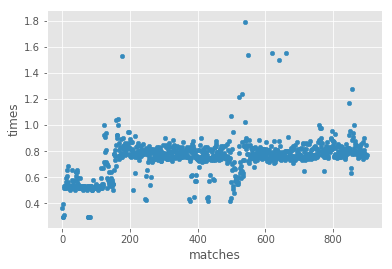

In [282]:
match_data.to_csv("2018_match_data_high_scale_all_feats_ml.txt",sep="\t",index=False)
print(len(current_data))
print(match_data["blue_win"].mean(axis=0))
d = pd.DataFrame(times, columns = ["times"])
d["matches"] = d.index.values+1
d.plot.scatter(x="matches",y="times")
plt.show()

In [348]:
#match1 = pd.read_csv("2017_match_data_high_scale_ml.txt",sep="\t")
match1 = pd.read_csv("2017_match_data_high_scale_all_feats_ml.txt",sep="\t")
#match1 = pd.read_csv("2017_match_data_team_comp.txt",sep="\t")
match1["year"] = 2017.0
#match2 = pd.read_csv("2018_match_data_high_scale_ml.txt",sep="\t")
match2 = pd.read_csv("2018_match_data_high_scale_all_feats_ml.txt",sep="\t")
#match2 = pd.read_csv("2018_match_data_team_comp.txt",sep="\t")
match2["year"] = 2018.0
match_all = match1.append(match2)
#print(match_all.dtypes)

0.557742402315


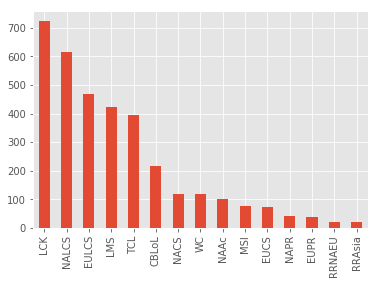

In [362]:
reset_dir()
from sklearn.preprocessing import StandardScaler
import analytics_utils
from analytics_utils import supervised_analysis
import importlib
importlib.reload(analytics_utils)
from sklearn.model_selection import train_test_split

#data = match_all.dropna(how = "any", axis=0).drop("league",axis=1)
def split(match_data, split = True):
    data = match_data.dropna(how = "any", axis=0).drop("league",axis=1, errors = "ignore")
    data_init = pd.get_dummies(data)
    cols = data_init.drop("blue_win",axis=1).columns.values
    y = data_init["blue_win"].values
    data = StandardScaler().fit_transform(data_init.drop("blue_win",axis=1))
    #print("Blue win rate: {:10.3f}".format(data_init["blue_win"].mean(axis=0)))
    if split:
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42, stratify = y)
        return y, cols, X_train, X_test, y_train, y_test
    else:
        return y, cols, data, data_init


#y, cols, data, data_init = split(match_all, False)
y,cols,X_train, X_test, y_train, y_test = split(match_all, True)
#m1 = all_matches[all_matches["year"] == 2017]
#m2 = all_matches[all_matches["year"] == 2018]
#y1, cols1, X_train1, X_test1, y_train1, y_test1 = split(m1)
#y1, _, data1, _ = split(m1, False)

league = "LCK"

m2 = match_all[match_all["league"] == league]
y2, _, data2, _ = split(m2, False)
print(match_all["blue_win"].value_counts(normalize=True).iloc[0])
match_all["league"].value_counts().plot.bar()
plt.show()

In [396]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def run_classifier(X_train, X_test, y_train, y_test, params = {"max_depth":1, "n_estimators":100, "learning_rate":.1, "colsample_bytree": .5, "subsample": .5, "gamma":0}, cv = True):
    cvresult = None
    clf = xgb.XGBClassifier(max_depth=params["max_depth"], n_estimators=params["n_estimators"], learning_rate=params["learning_rate"], colsample_bytree = params["colsample_bytree"], subsample=params["subsample"], gamma = params["gamma"])
    xgb_param = clf.get_xgb_params()
    if cv:
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['error'], early_stopping_rounds=50, stratified=True, seed=1301)
    #print(cvresult)
    #clf.set_params(n_estimators=cvresult.shape[0])
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    #print('Training AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print("Training accuracy: {:10.3f}".format(train_acc))
    
    #pred = clf.predict_proba(X_test, ntree_limit=cvresult.shape[0])
    #print('Testing AUC:', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print("Testing accuracy: {:10.3f}".format(test_acc))
    
    #print('Best number of trees = {}'.format(cvresult.shape[0]))
    #train_pred = clf.predict(X_train)
    #test_pred = clf.predict(X_test)
    #train_acc = accuracy_score(y_train, train_pred)
    #test_acc = accuracy_score(y_test, test_pred)
    #print("Training accuracy: {:10.3f}".format(train_acc))
    #print("Testing accuracy: {:10.3f}".format(test_acc))
    return clf, cvresult


In [400]:
#params = {"max_depth":3, "n_estimators":70, "learning_rate":.08, "colsample_bytree": .5, "subsample": .5, "gamma":0}
params={"max_depth":3, "n_estimators":70, "learning_rate":.08, "colsample_bytree": .5, "subsample": .5, "gamma":0}
gbm,cvresult = run_classifier(X_train, X_test, y_train, y_test, params, cv=False)
if cvresult is not None:
    cvresult["train_acc"] = 1 - cvresult["train-error-mean"]
    cvresult["test_acc"] = 1 - cvresult["test-error-mean"]
    print(cvresult.tail())

Training accuracy:      0.720
Testing accuracy:      0.643
     test-error-mean  test-error-std  train-error-mean  train-error-std  \
229         0.369249        0.009341          0.162971         0.004116   
230         0.367175        0.009551          0.162039         0.003909   
231         0.365513        0.008721          0.160796         0.003070   
232         0.365100        0.007246          0.160796         0.002972   
233         0.363441        0.006320          0.159760         0.002233   

     train_acc  test_acc  
229   0.837029  0.630751  
230   0.837961  0.632825  
231   0.839204  0.634487  
232   0.839204  0.634900  
233   0.840240  0.636559  


In [401]:
leagues = []
bwin = []
accs = []
num_matches = []
for ii in match_all["league"].unique():
    leagues.append(ii)
    m2 = match_all[match_all["league"] == ii]
    bwin.append(m2["blue_win"].value_counts(normalize=True).iloc[0])
    y2, _, data2, _ = split(m2, False)
    pred = gbm.predict(data2)
    acc = accuracy_score(y2, pred)
    accs.append(acc)
    num_matches.append(m2.shape[0])
    #print("Accuracy for {}: {:10.4f}\n".format(ii,acc))
    
s = pd.Series(bwin, index=leagues)
df = pd.DataFrame(s, columns = ["largest_class"])
df["test_acc"] = accs
df["info_gain"] = df["test_acc"]- df["largest_class"]
df["num_matches"] = num_matches
display(df.sort_values(by="info_gain", ascending=False))

,largest_class,test_acc,info_gain,num_matches
NACS,0.621849,0.798319,0.176471,119
EUCS,0.541667,0.690141,0.148474,72
LMS,0.575472,0.718009,0.142538,424
TCL,0.555838,0.684478,0.128641,394
EULCS,0.542553,0.663830,0.121277,470
WC,0.567797,0.683761,0.115964,118
NAAc,0.509804,0.623762,0.113958,102
LCK,0.552486,0.661602,0.109116,724
NALCS,0.564935,0.636364,0.071429,616
CBLoL,0.576037,0.640553,0.064516,217


In [86]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
#clf = RandomForestClassifier()
rfe = RFE(clf, 20, verbose = 0)
rfe.fit(X_train, y_train)
score = rfe.score(X_test, y_test)
print(score)
rfe.score(X_train, y_train)

0.563947633434


In [90]:
fi1 = pd.DataFrame(gbm.feature_importances_,columns = ["importance"],index=cols1).sort_values(by="importance", ascending=False)
#fi1.head(20)

In [89]:
fi2 = pd.DataFrame(gbm.feature_importances_,columns = ["importance"],index=cols1).sort_values(by="importance", ascending=False)
#fi2.head(20)

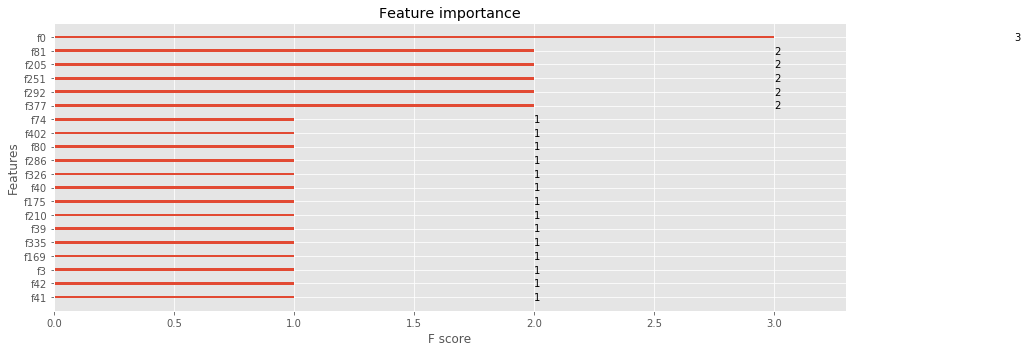

In [61]:
fig, ax =  plt.subplots(1,1,figsize=(12,5))
xgb.plot_importance(gbm, ax= ax, max_num_features = 20)
plt.tight_layout()
plt.show()

In [59]:
s = pd.Series(all_matches.columns.values)
s.index = s.index+1
display(all_matches["blue_win"].value_counts(normalize=True))
print(s.iloc[169])
print(s.iloc[74])
print(s.iloc[71])

1    0.557715
0    0.442285
Name: blue_win, dtype: float64

blue_Middle_d
red_Top_gspd
red_Top_fbaron


In [318]:
sup = supervised_analysis(data,y,cols)
logit, log_auc = sup.fit("Logit")
ada, ada_auc = sup.fit("Adaboost")
rforest, forest_auc = sup.fit("Random Forest")
print(log_auc)
print(ada_auc)
print(forest_auc)
s = [ada[:10], logit[:10], rforest[:10]]
names = ["adaboost", "logit", "randomforest"]
feature = "importance"
table = display_side_by_side(s, names, feature)
display(table)

,adaboost,importance,logit,importance,randomforest,importance
1,blue_ADC_gspd,0.04,red_Middle_a,19.703597,blue_ADC_doubles,0.019296
2,blue_Jungle_result,0.04,red_ADC_fdtime,16.276259,red_ADC_earnedgoldshare,0.011498
3,blue_ADC_monsterkillsownjungle,0.04,blue_Support_gdat15,15.923741,red_Top_dmgtochampsperminute,0.011198
4,blue_Middle_monsterkills,0.02,blue_ADC_gspd,15.831655,blue_ADC_kpm,0.011098
5,blue_Support_doubles,0.02,blue_ADC_doubles,15.507914,blue_Middle_gspd,0.010298
6,blue_Support_fb,0.02,red_Top_fbaron,15.345324,red_ADC_ft,0.009898
7,blue_ADC_fd,0.02,blue_Support_fbaron,14.555396,blue_Support_xpdat10,0.009598
8,blue_Support_dmgtochamps,0.02,blue_Support_result,-13.513669,blue_ADC_wpm,0.009398
9,red_Top_wcpm,0.02,red_Jungle_xpdat10,13.296403,blue_Middle_wardshare,0.009098
10,red_Top_wardkills,0.02,blue_Top_a,-12.781295,blue_ADC_triples,0.008798


In [241]:
print(matches_16["league"].unique())
print(matches_17["league"].unique())
print(matches_18["league"].unique())

['LCK' 'CBLoL' 'KeSPA' 'EUCS' 'EULCS' 'LMS' 'NALCS' 'NACS' 'EU PR' 'NA PR'
 'IWCI' 'LCK PR' 'MSI' 'IWCQ' 'WC' 'TCL']
['NALCS' 'LCK' 'NACS' 'EULCS' 'TCL' 'LMS' 'EUCS' 'CBLoL' 'RRNAEU' 'RRAsia'
 'NAPR' 'EUPR' 'MSI' 'WC']
['LCK' 'TCL' 'NAAc' 'EULCS' 'NALCS' 'LMS' 'CBLoL']


### To Consider

I'm getting max 60% accuracy on the match data for both 2017 and 2018 with a naive accuracy of 54% (blue side advantage)... so my model does 6% better than random. How to improve predictions?

- Include league information (standardize this across years and make a union of all leagues)
- Is team composition predictive? - seems to be "no"
- Put 2017 and 2018 together: make a plot of training and testing accuracy vs training sample size
- Try using xgboost - this does well
- Try doing feature selection/ which features are predictive
- Different models for different leagues or test model on different leauges? - it performs differently
- Use 2016 match data as well to get more data points -> use 2015 player stats with games played, no scale. 
- Use xgboost on team comp/early game?

historical odds:
http://www.oddsportal.com/esports/china/league-of-legends-lol-pro-league/results/

## OSHU DATA


In [ ]:
os.chdir("C:\\Users\Brook Wassie\Dropbox\My Documents\Fraenkel Lab\Misc\OSHU analysis")
df = pd.read_csv("diffbind_matrix.txt",sep="\t")
sn = pd.Series([0.33,0.25,0.27,0.32,0.27,0.26,0.16,0.24,0.19,0.16,0.39,0.22,0.16,0.15,0.12])
columns = [col.replace("DNA171220LH_","").replace("_merged","") for col in df.columns.values]
df.columns = columns
#df = df.divide(sn.values,axis=1)
for_pca = np.log2(df.T)
labels = [s.split("_")[0] for s in for_pca.index.values]
print(labels)
display(df.head())
display((df.divide(sn.values,axis=1)).head())

In [218]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

class scale_pca():
    def __init__(self,data,labels, scale=True):
        if scale:
            scaler = StandardScaler()
            self.scaled = scaler.fit_transform(data)
        else:
            self.scaled = data
        self.data = data
        self.labels = pd.Series(labels)
        
    def pca(self,save=False):
        pca = PCA()
        y = self.labels
        pca_transform = pca.fit(self.scaled).transform(self.scaled)
        dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
        components = pd.DataFrame(np.round(pca.components_, 4), columns = self.data.keys())
        components.index = dimensions
        components = components[components.iloc[0,:].sort_values(ascending=False).index]
        ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
        variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
        variance_ratios.index = dimensions
        df = pd.concat([variance_ratios, components],axis=1)
        print("\nContributions to PCA components:")
        display(df.head())
        target_names = pd.unique(y)
        print(target_names)
        plt.figure(figsize=(10,5))
        all_colors = ['blue', 'red','green','brown','yellow','cyan','black']
        colors = all_colors[:target_names.shape[0]]
        lw = 2
        for color, i in zip(colors, target_names):
            plt.scatter(pca_transform[y == i, 0], pca_transform[y == i, 1], color=color, alpha=.8, lw=lw,
                        label=i)
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        for label, x, y in zip(self.data.index.values, pca_transform[:, 0], pca_transform[:, 1]):
            plt.annotate(
            label,
            xy=(x, y), xytext=(-20, -20),
            textcoords='offset points', va='bottom')

        plt.title('PCA plot')
        plt.xlabel("Component 1: {}".format(np.round(ratios,4)[0][0]))
        plt.ylabel("Component 2: {}".format(np.round(ratios,4)[1][0]))
        plt.tight_layout()
        if save:
            plt.savefig("PCA.pdf")
            plt.show()
        else:
            plt.show()
        return pca_transform, target_names


Contributions to PCA components:


,Explained Variance,chr3_194391239_194393873,chr21_38443586_38448819,chr5_150078338_150082316,chr16_70487617_70489348,chr10_71928656_71930939,chr4_153452315_153460494,chr6_35225491_35229412,chr2_135809399_135812796,chr9_133568559_133570508,...,chr11_48961586_48962901,chr7_102157547_102158699,chr1_49275_50610,chr16_90172904_90173903,chr17_58196908_58198096,chr3_195226589_195227573,chr19_gl000208_random_83016_83911,chr2_92300716_92301408,chr10_51368277_51373805,chr5_46363919_46364466
Dimension 1,0.7564,0.0089,0.0089,0.0089,0.0089,0.0089,0.0088,0.0088,0.0088,0.0088,...,-0.0033,-0.0034,-0.0035,-0.0035,-0.0035,-0.0035,-0.0040,-0.0046,-0.0047,-0.0050
Dimension 2,0.0668,-0.0003,0.0012,0.0013,-0.0011,0.0001,0.0035,0.0007,0.0016,-0.0016,...,-0.0002,0.0083,0.0139,0.0044,0.0139,0.0139,-0.0025,-0.0026,0.0100,-0.0063
Dimension 3,0.0430,-0.0010,-0.0003,0.0005,0.0000,0.0004,-0.0027,0.0003,0.0013,0.0019,...,-0.0195,-0.0274,0.0260,0.0082,0.0260,0.0260,0.0238,-0.0165,0.0111,-0.0159
Dimension 4,0.0325,0.0013,0.0002,-0.0002,-0.0013,0.0003,-0.0009,-0.0003,-0.0035,0.0015,...,0.0256,-0.0059,-0.0117,-0.0037,-0.0117,-0.0117,0.0010,-0.0099,0.0149,0.0012
Dimension 5,0.0213,0.0007,-0.0003,0.0010,-0.0013,0.0022,0.0009,0.0020,0.0020,-0.0010,...,-0.0081,0.0091,-0.0040,-0.0263,-0.0040,-0.0040,0.0087,-0.0193,-0.0000,-0.0234


['CTR' 'HD']


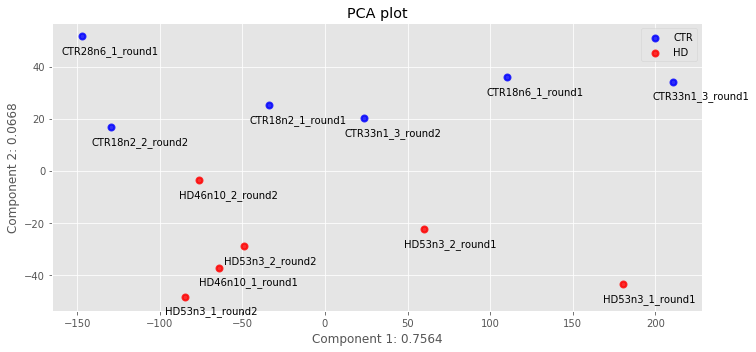

In [238]:
import sys, importlib
sys.path.append('.')
sys.path.append("C:\\Users\Brook Wassie\Dropbox\ssh stuff\\notebooks")
import pca
importlib.reload(pca)

pca = scale_pca(for_pca,labels, True)

y = labels

pca_transform, target_names = pca.pca(True)

In [213]:
cwd = os.getcwd()
os.chdir("C:\\Users\Brook Wassie\Dropbox\My Documents\Fraenkel Lab\Projects\HD\MSNS\\11.18.16 iMSNs ATAC\differential analysis")
df = pd.read_csv("adult_onset_diffbind_matrix.txt",sep="\t")
for_pca = np.log2(df.T)
labels = ["HD" if "HD" in s else "CTR" for s in for_pca.index.values]

['CTR',
 'CTR',
 'CTR',
 'CTR',
 'CTR',
 'CTR',
 'CTR',
 'CTR',
 'HD',
 'HD',
 'HD',
 'HD']

In [230]:
os.chdir("C:\\Users\Brook Wassie\Dropbox\My Documents\Fraenkel Lab\Projects\HD\MSNS\\k4me3 MSNs ChIP\All Rounds")
peak = pd.read_csv("k4me3_CTR_vs_HD_edger.bed", sep="\t")
peak[peak["Fold"] < 0].to_csv("HD_up_edger.bed",sep="\t",index=False,header=False)

In [226]:
peak[peak["Fold"] < 1].shape

(3574, 11)

In [236]:
hd = pd.read_csv("HD_up_edger.bed_hg19_anno.txt",sep="\t")
hd["dist"] = hd["Distance to TSS"]
ctr = pd.read_csv("CTR_up_edger.bed_hg19_anno.txt",sep="\t")
ctr["dist"] = ctr["Distance to TSS"]
print(hd.shape)
print(hd[hd["dist"].abs() < 2000].shape)
hd[hd["dist"].abs() < 2000]["Gene Name"].to_csv("k4me3_HD_prom_genes.txt",sep="\t",index=False,header=False)
ctr[ctr["dist"].abs() < 2000]["Gene Name"].to_csv("k4me3_CTR_prom_genes.txt",sep="\t",index=False,header=False)

(1791, 22)
(1465, 22)


In [237]:
df = pd.read_csv("diffbind_matrix.txt",sep="\t")
for_pca = np.log2(df.T)
labels = ["HD" if "HD" in s else "CTR" for s in for_pca.index.values]